In [15]:
%%bash
# 增加更新
git add .

git remote -v

git commit -m '更新ch7 #5 change 2021-07028'

git push origin master

origin	git@github.com:ustchope/dlwpn.git (fetch)
origin	git@github.com:ustchope/dlwpn.git (push)
[master 4df8f1d] 更新ch7 #5 change 2021-07028
 2 files changed, 1526 insertions(+), 408 deletions(-)


To github.com:ustchope/dlwpn.git
   6ca0969..4df8f1d  master -> master


time: 6.23 s (started: 2021-07-28 21:59:08 +08:00)


In [1]:
# 自动计算cell的计算时间
%load_ext autotime

#设置使用的gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[2] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU") 

time: 6.65 s (started: 2021-07-28 20:38:15 +08:00)


In [2]:
%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

time: 32.6 ms (started: 2021-07-28 20:38:22 +08:00)


# 使用Keras：深入探讨

**本章包含**
* 创建 Keras 模型的不同方法：Sequential 类、Functional API 和模型子类化
* 如何使用内置的 Keras 训练和评估循环——包括如何使用自定义指标和自定义损失
* 使用 Keras 回调进一步自定义训练的进行方式
* 使用 TensorBoard 监控您的训练和评估指标随着时间的推移
* 如何从头开始编写自己的训练和评估循环

您开始对 Keras 有了一定的经验——熟悉 Sequential Dense 模型、层和用于训练、评估和推理的内置 API——compile()、fit()、evaluate()、 和 predict() 。 您甚至在第 3 章中学习了如何从 Layer 类继承以创建自定义层，以及如何使用 TensorFlow GradientTape 实现逐步训练循环。

在接下来的章节中，我们将深入研究计算机视觉、时间序列预测、自然语言处理和生成式深度学习。 这些复杂的应用程序将需要更多
比顺序架构和默认的 fit() 循环。 所以让我们先把你变成 Keras 专家！ 在本章中，您将全面了解使用 Keras API 的关键方法：处理接下来将遇到的高级深度学习用例所需的一切。

## 工作流程

Keras API 的设计遵循逐步公开复杂性的原则：易于上手，但可以处理高复杂性的用例，只需要在每一步进行增量学习。 简单的用例应该是简单易懂的，任意高级的工作流程应该是：无论你想做的事情多么小众和多么复杂，都应该有一条清晰的路径。 一条建立在您从更简单的工作流程中学到的各种知识之上的路径。 这意味着您可以从初学者成长为专家，并且仍然使用相同的工具——只是方式不同。

因此，没有一种使用 Keras 的“真正”方式。 相反，Keras 提供了一系列工作流程，从非常简单到非常灵活。 构建 Keras 模型有不同的方法，训练它们的方法也不同，以满足不同的需求。 由于所有这些工作流都基于共享 API，例如层和模型，因此任何工作流中的组件都可以在任何其他工作流中使用：它们都可以相互通信。

## 构建 Keras 模型的不同方式

在 Keras 中构建模型有 3种API：
* Sequential 模型，最容易上手的 API——它基本上是一个 Python 列表。 因此，它仅限于简单的层堆叠。
* Functional API，专注于类似图的模型架构。 它代表了可用性和灵活性之间的一个很好的中间点，因此，它是最常用的模型构建 API。
* 模型子类化，一个低级选项，您可以从头开始自己编写所有内容。 如果您想完全控制每一件小事，这是理想的选择。 但是，您将无法访问许多内置的 Keras 功能，并且更容易犯错误。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsvjgio2rwj31980dedhv.jpg)

### 顺序模型

构建 Keras 模型的最简单方法是 Sequential 模型，您已经知道：

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
 layers.Dense(64, activation="relu"),
 layers.Dense(10, activation="softmax")
])

time: 2.34 s (started: 2021-07-28 20:38:49 +08:00)


请注意，可以通过方法增量构建相同的模型，类似于 Python 列表的 add() 方法： append()

In [12]:
model = keras.Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

time: 5.67 ms (started: 2021-07-28 06:42:53 +08:00)


你在第 4 章中已经看到，层只有在第一次被调用时才会被构建（也就是说，创建它们的权重）。 这是因为层权重的形状取决于其输入的形状：在知道输入形状之前，无法创建它们。

因此，上面的 Sequential 模型没有任何权重，直到您在某些数据上实际调用它，或者使用输入形状调用其方法：

In [7]:
model.weights

ValueError: Weights for model sequential_1 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

time: 1.11 s (started: 2021-07-27 15:31:37 +08:00)


In [8]:
# 构建模型——现在模型将需要 shape (3,)的样本。 None输入形状表明批量大小可以是任何东西。
model.build(input_shape=(None, 3))
model.weights

[<tf.Variable 'dense_2/kernel:0' shape=(3, 64) dtype=float32, numpy=
 array([[-0.00819355,  0.15351084, -0.23104338, -0.09885751,  0.2628876 ,
         -0.20201147,  0.08822173,  0.28065652, -0.25919423,  0.14183763,
         -0.07550877,  0.26725054, -0.13888718, -0.16665961,  0.02244398,
         -0.13757768, -0.23935236, -0.14157756, -0.10289697, -0.23451564,
          0.00623435, -0.19813038, -0.21516216,  0.23319238,  0.11614984,
         -0.04733825,  0.26974314,  0.1734513 ,  0.1687446 ,  0.15775165,
          0.10909671, -0.0678076 ,  0.22353363, -0.23721272,  0.05471078,
          0.21833688,  0.2523135 ,  0.25877118,  0.14999378, -0.14234525,
          0.27807528,  0.0214887 ,  0.02348122,  0.16687799,  0.11501056,
         -0.23760428, -0.22343895,  0.10037541,  0.0794273 , -0.02018911,
         -0.2630825 ,  0.07161856, -0.05101891, -0.14118814, -0.2773213 ,
         -0.0763635 , -0.20710817,  0.11496246,  0.17371288,  0.08795267,
          0.23122561,  0.03001878,  0.19550

time: 227 ms (started: 2021-07-27 15:33:48 +08:00)


模型构建完成后，您可以通过方法显示其内容，该方法提供的 summary() 便于调试：

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________
time: 2.52 ms (started: 2021-07-27 15:34:21 +08:00)


如您所见，您的模型恰好被命名为“sequential_1”。 实际上，您可以为 Keras 中的所有内容命名——每个模型、每个层。 像这样：

In [13]:
model = keras.Sequential(name="my_example_model")
model.add(layers.Dense(64, activation="relu", name="my_first_layer"))
model.add(layers.Dense(10, activation="softmax", name="my_last_layer"))
model.build((None, 3))
model.summary()

Model: "my_example_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_first_layer (Dense)       (None, 64)                256       
_________________________________________________________________
my_last_layer (Dense)        (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________
time: 220 ms (started: 2021-07-28 06:43:06 +08:00)


在逐步构建 Sequential 模型时，能够在添加每一层后打印当前模型外观的摘要非常有用。 但是在构建模型之前您无法打印摘要！ 实际上有一种方法可以让您的 Sequential 即时构建：只需提前声明模型输入的形状。 您可以通过 Input 类执行此操作：

In [16]:
model = keras.Sequential()
#使用 Input 来声明输入的形状。 请注意，参数 Input shape 必须是每个样本的形状，而不是一批的形状。
model.add(layers.InputLayer(input_shape=(4,))) 
model.add(layers.Dense(64, activation="relu"))

time: 34.5 ms (started: 2021-07-27 15:39:42 +08:00)


现在，您可以跟踪模型的输出形状如何随着您添加 summary() 更多层而发生变化：

In [17]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                320       
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________
time: 3.05 ms (started: 2021-07-27 15:40:16 +08:00)


In [18]:
model.add(layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 970
Trainable params: 970
Non-trainable params: 0
_________________________________________________________________
time: 21.2 ms (started: 2021-07-27 15:40:46 +08:00)


在处理以复杂方式转换输入的层时，这是一个非常常见的调试工作流程，例如您将在第 8 章中学习的卷积层。

### 函数型API

Sequential 模型易于使用，但其适用性极其有限：它只能表达具有单个输入和单个输出的模型，以顺序方式一层接一层地应用。 在实践中，经常会遇到具有多个输入（例如，图像及其元数据）、多个输出（您想要预测数据的不同事物）或非线性拓扑的模型。

在这种情况下，您可以使用 Functional API 构建模型。 这是您在野外使用时会遇到的大多数 Keras 模型。 它既有趣又强大——感觉就像在玩乐高积木。

**一个简单的例子** 

让我们从简单的事情开始：我们在上一节中使用的两层堆栈。 它的功能 API 版本如下所示：

In [19]:
inputs = layers.Input(shape=(3,), name="my_input")
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

time: 35.3 ms (started: 2021-07-27 15:54:47 +08:00)


In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_input (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________
time: 2.38 ms (started: 2021-07-27 15:54:54 +08:00)


让我们一步一步来。

我们首先声明了一个Input（请注意，您也可以为这些输入对象命名，例如输入其他所有内容）：

In [21]:
inputs = layers.Input(shape=(3,), name="my_input")

time: 2.66 ms (started: 2021-07-27 16:05:41 +08:00)


此对象保存有关模型将输入处理的数据的形状和数据类型的信息：

In [22]:
# 该模型将处理每个样本具有 shape 的批次。 每批次的 (3,) 样本数量是可变的（由批次大小表示）。
inputs.shape

TensorShape([None, 3])

time: 4.63 ms (started: 2021-07-27 16:06:07 +08:00)


In [25]:
# 这些批次将具有 dtype float32
inputs.dtype

tf.float32

time: 3.85 ms (started: 2021-07-27 16:08:45 +08:00)


我们称这样的对象为“符号张量”。 它不包含任何实际数据，但它对模型在使用时将看到的实际数据张量的规格进行编码。 它代表未来的数据张量。

接下来，我们创建了一个层并在输入上调用它：

In [26]:
features = layers.Dense(64, activation="relu")(inputs)

time: 31.7 ms (started: 2021-07-27 16:09:43 +08:00)


所有 Keras 层都可以在数据的真实张量或这些符号张量上调用。 在后一种情况下，它们返回一个新的符号张量，带有更新的形状和 dtype 信息：

In [28]:
features.dtype

tf.float32

time: 2.46 ms (started: 2021-07-27 16:10:28 +08:00)


获得最终输出后，我们通过在构造函数中指定其输入和输出来实例化模型：

In [29]:
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

time: 35.1 ms (started: 2021-07-27 16:11:02 +08:00)


这是我们模型的摘要：

In [30]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_input (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________
time: 3.49 ms (started: 2021-07-27 16:11:47 +08:00)


**多输入多输出型号**

与这个玩具模型不同，大多数深度学习模型看起来不像列表——它们看起来像图表。 例如，它们可能有多个输入或多个输出。 正是对于这种模型，Functional API 才真正闪耀。

假设您正在构建一个系统来按优先级对客户支持票进行排名，并将它们路由到适当的部门。 您的模型具有三个输入：
* 票的标题（文本输入）
* 工单正文（文本输入）
* 用户添加的任何标签（分类输入，此处假定为单热编码）

我们可以将文本输入编码为大小为词汇表大小的 1 和 0 的数组（有关文本编码技术的详细信息，请参见第 11 章）。

您的模型还有两个输出：
* 票证的优先级分数，一个介于 0 和 1 之间的标量（sigmoid 输出）
* 应该处理工单的部门（部门集上的 softmax）

您可以使用 Functional API 用几行代码构建此模型：

In [31]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

# 定义模型输入
title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body") 
tags = keras.Input(shape=(num_tags,), name="tags")

# 将输入特征组合成单个张量 ，通过将它们连接起来
features = layers.Concatenate()([title, text_body, tags])
# 应用中间层将输入特征重新组合成更丰富的表示
features = layers.Dense(64, activation="relu")(features)

# 定义模型输出
priority = layers.Dense(1, activation="sigmoid", name="priority")(features) 
department = layers.Dense(num_departments, activation="softmax", name="department")(features) 

# 通过指定其输入和输出来创建模型
model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

time: 58.6 ms (started: 2021-07-27 16:16:43 +08:00)


In [32]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, 10000)]      0                                            
__________________________________________________________________________________________________
text_body (InputLayer)          [(None, 10000)]      0                                            
__________________________________________________________________________________________________
tags (InputLayer)               [(None, 100)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 20100)        0           title[0][0]                      
                                                                 text_body[0][0]            

In [33]:
from tensorflow.keras.utils import plot_model

time: 383 µs (started: 2021-07-27 16:17:10 +08:00)


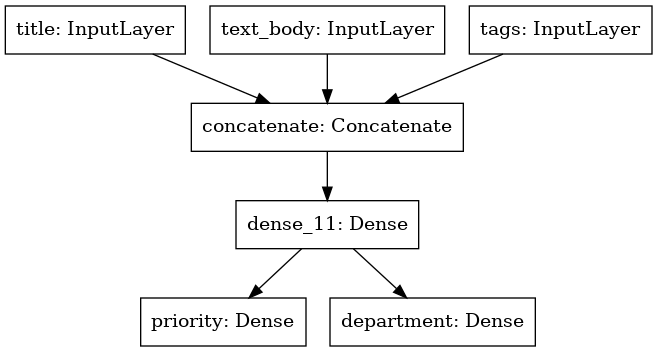

time: 385 ms (started: 2021-07-27 16:18:14 +08:00)


In [36]:
plot_model(model)

函数式 API 是一种简单的、类似于乐高积木的方法，但非常灵活，可以定义此类任意层图。

**训练多输入多输出模型** 

您可以用与训练序列模型大致相同的方式训练模型，方法是使用输入和输出数据列表调用 fit()。 这些数据列表应遵循与传递给 Model() 构造函数的顺序相同的顺序。

In [39]:
import numpy as np

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size)) 
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments)) 

model.compile(optimizer="adam",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])

model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=10)

Epoch 1/10
40/40 [==============================] - 1s 13ms/step - loss: 14.2303 - priority_loss: 0.3307 - department_loss: 13.8996 - priority_mean_absolute_error: 0.5008 - department_accuracy: 0.2625
Epoch 2/10
40/40 [==============================] - 1s 13ms/step - loss: 7.4399 - priority_loss: 0.3307 - department_loss: 7.1092 - priority_mean_absolute_error: 0.5008 - department_accuracy: 0.2422
Epoch 3/10
40/40 [==============================] - 1s 14ms/step - loss: 12.3965 - priority_loss: 0.3307 - department_loss: 12.0658 - priority_mean_absolute_error: 0.5008 - department_accuracy: 0.2453
Epoch 4/10
40/40 [==============================] - 1s 14ms/step - loss: 30.4116 - priority_loss: 0.3307 - department_loss: 30.0810 - priority_mean_absolute_error: 0.5008 - department_accuracy: 0.2508
Epoch 5/10
40/40 [==============================] - 1s 14ms/step - loss: 31.4993 - priority_loss: 0.3307 - department_loss: 31.1687 - priority_mean_absolute_error: 0.5008 - department_accuracy: 0.23

time: 6.89 s (started: 2021-07-27 16:23:27 +08:00)


In [40]:
model.evaluate([title_data, text_body_data, tags_data],
               [priority_data, department_data])

40/40 [==============================] - 1s 12ms/step - loss: 60.3639 - priority_loss: 0.3307 - department_loss: 60.0333 - priority_mean_absolute_error: 0.5008 - department_accuracy: 0.2453


[60.36393356323242,
 0.3306571841239929,
 60.03327560424805,
 0.50081866979599,
 0.24531249701976776]

time: 842 ms (started: 2021-07-27 16:23:56 +08:00)


In [41]:
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

time: 451 ms (started: 2021-07-27 16:24:05 +08:00)


如果您不想依赖输入顺序（例如因为您有许多输入或输出），您还可以利用您为对象和输出层提供的名称，并通过字典传递输入数据：

In [42]:
model.compile(optimizer="adam", 
              loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"},
              metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          {"priority": priority_data, "department": department_data},
          epochs=1)

40/40 [==============================] - 1s 13ms/step - loss: 92.4883 - priority_loss: 0.3307 - department_loss: 92.1576 - priority_mean_absolute_error: 0.5008 - department_accuracy: 0.2508


time: 1.49 s (started: 2021-07-27 16:27:12 +08:00)


In [43]:
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
               {"priority": priority_data, "department": department_data})

40/40 [==============================] - ETA: 0s - loss: 47.3248 - priority_loss: 0.3288 - department_loss: 46.9961 - priority_mean_absolute_error: 0.4988 - department_accuracy: 0.06 - 1s 13ms/step - loss: 47.3725 - priority_loss: 0.3307 - department_loss: 47.0418 - priority_mean_absolute_error: 0.5008 - department_accuracy: 0.0648


[47.372493743896484,
 0.3306571841239929,
 47.04183578491211,
 0.50081866979599,
 0.06484375149011612]

time: 1.05 s (started: 2021-07-27 16:27:22 +08:00)


In [44]:
priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

time: 466 ms (started: 2021-07-27 16:27:32 +08:00)


**函数API的威力：访问层连接**

功能模型是一种显式的图形数据结构。 这使得检查层如何连接成为可能，重用以前的图节点和（层输出）作为新模型的一部分。 它也非常符合大多数研究人员在考虑深度神经网络时使用的“心理模型”：层图。

这实现了两个重要的用例：模型可视化和特征提取。 让我们来看看。

> 绘制层连接性

让我们可视化我们刚刚定义的模型（模型的）的连通性。 您可以使用 plot_model() 实用程序将功能模型绘制为图形：

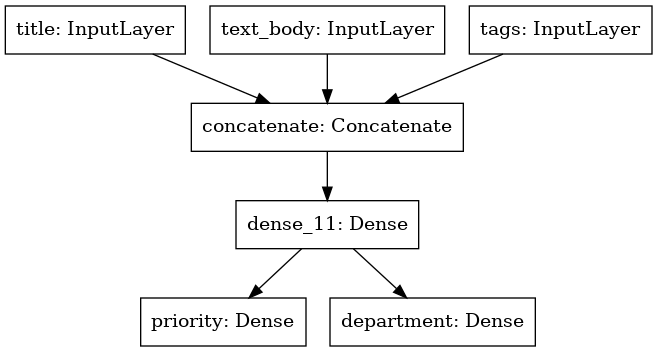

time: 905 ms (started: 2021-07-27 16:30:18 +08:00)


In [46]:
keras.utils.plot_model(model, "ticket_classifier.png")

您可以将模型中每一层的输入和输出形状添加到此图中，这在调试过程中会有所帮助：

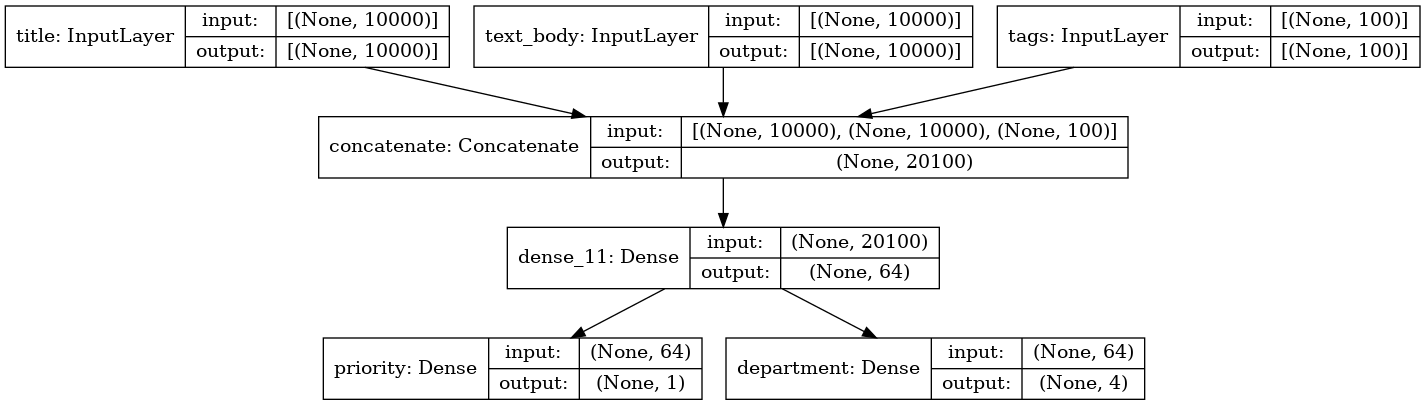

time: 766 ms (started: 2021-07-27 16:31:02 +08:00)


In [47]:
keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

张量形状中的“None”表示批次大小：此模型允许任何大小的批次。

> 使用函数模型进行特征提取

In [49]:
model.layers

time: 3.24 ms (started: 2021-07-27 16:32:13 +08:00)


In [50]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

time: 3.97 ms (started: 2021-07-27 16:32:29 +08:00)


In [51]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

time: 3.84 ms (started: 2021-07-27 16:33:04 +08:00)


这使您能够进行特征提取：创建重用另一个模型的中间特征的模型。 假设您想向我们上面定义的模型添加另一个输出——您还想预测一个给定的问题单需要多长时间来解决，一种难度等级。 您可以通过超过 3 个类别的分类层来做到这一点——“快速”、“中等”、“困难”。 您无需从头开始重新创建和重新训练模型！ 您可以从之前模型的中间特征开始，因为您可以访问它们。 像这样：

In [52]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

new_model = keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department, difficulty])

time: 26.7 ms (started: 2021-07-27 16:35:19 +08:00)


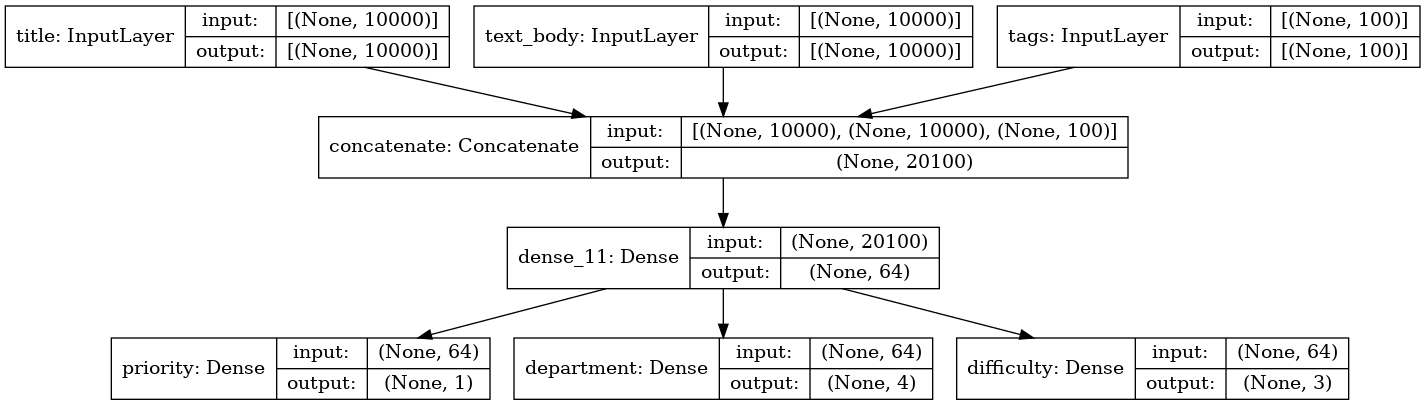

time: 627 ms (started: 2021-07-27 16:35:28 +08:00)


In [53]:
keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)

### 子类化Model类

您应该了解的最后一个模型构建模式是最高级的模式：模型子类化。 您已经在第 3 章中学习了如何将类子类化以创建图层自定义图层。 子类化模型非常相似：
* 在 init 方法中，定义模型将使用的层。
* 在 call 方法中，定义模型的前向传递，重用先前创建的层。
* 实例化您的子类并在数据上调用它以创建其权重。

**将我们之前的示例重写为子类模型**

In [58]:
# 译者注：这个就和Pytorch的方式极其相似了，只不过Pytorch用的Forward()函数，而不是call()

class CustomerTicketModel(keras.Model):
    
    def __init__(self, num_departments):
        # 不要忘记调用super构造函数！ 
        super().__init__() 
        
        # 在构造函数中定义子层。
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid") 
        self.department_classifier = layers.Dense(num_departments, activation="softmax")
    
    # 在call方法中定义前向传递。
    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

time: 1.91 ms (started: 2021-07-27 16:49:37 +08:00)


一旦定义了模型，就可以实例化它。 请注意，它只会在您第一次在某些数据上调用它时创建它的权重——很像层子类。

In [59]:
model = CustomerTicketModel(num_departments=4)

priority, department = model({"title": title_data, "text_body": text_body_data, "tags": tags_data})

time: 205 ms (started: 2021-07-27 16:51:04 +08:00)


到目前为止，一切看起来都与图层子类化非常相似，这是您在第 3 章中已经遇到的工作流程。那么，图层子类和模型子类之间的区别是什么？ 很简单：“层”是您用来创建模型的构建块，而“模型”是您实际训练、导出以进行推理等的顶级对象。简而言之，模型具有 fit() ，evaluate() 和 predict() 方法。 层没有。 除此之外，这两个类实际上是相同的（另一个区别是您可以将模型转换为磁盘上的文件——我们将在几节中介绍保存）。

您可以像 Sequential 或 Functional 模型一样编译和训练子类：

In [60]:
model.compile(optimizer="adam",
              loss=["mean_squared_error", "categorical_crossentropy"], 
              metrics=[["mean_absolute_error"], ["accuracy"]])

model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data}, 
          [priority_data, department_data],
          epochs=1)

40/40 [==============================] - 1s 13ms/step - loss: 5.5570 - output_1_loss: 0.3218 - output_2_loss: 5.2352 - output_1_mean_absolute_error: 0.4916 - output_2_accuracy: 0.2625


time: 1.38 s (started: 2021-07-27 17:01:38 +08:00)


In [61]:
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
               [priority_data, department_data])

priority_preds, department_preds = model.predict( {"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 1s 12ms/step - loss: 3.2431 - output_1_loss: 0.3290 - output_2_loss: 2.9140 - output_1_mean_absolute_error: 0.4992 - output_2_accuracy: 0.2125
time: 1.85 s (started: 2021-07-27 17:02:07 +08:00)


您作为 and 传递的结构必须与 call() 返回的损失指标完全匹配——因为我们返回了两个元素的列表，所以 loss 和 be 两个元素的列表也应该如此。

您作为损失和指标传递的结构必须与 call() 返回的内容完全匹配——因为我们返回了两个元素的列表，所以损失和指标应该是两个元素的列表。

输入数据的结构必须与 call() 方法所期望的完全匹配，目标数据的结构必须与 call() 方法返回的完全匹配。 在这里，输入数据必须是具有 3 个键（'title'、'text_body' 和 'tags'）的 dict，目标数据必须是包含两个元素的列表。

模型子类化工作流是构建模型最灵活的方式：它使您能够构建无法表示为层的有向无环图的模型——例如，想象一下，call() 方法在循环中使用层的模型， 甚至递归调用它们。 因为一切皆有可能——您负责。

**当心：哪些子分类模型不支持**

这种自由是有代价的：对于子类模型，您要负责更多的模型逻辑，这意味着您的潜在错误面要大得多。 因此，您将有更多的调试工作要做。 您正在开发一个新的 Python 对象，而不仅仅是拼凑乐高积木。

函数模型和子类模型在本质上也有很大的不同：功能模型是一种显式的数据结构 - 一个层图，您可以查看、检查和修改它。 同时，子类模型是一段字节代码——一个带有 call() 方法的 Python 类，其中包含原始代码。 这是子类化工作流灵活性的来源——你可以编写任何你喜欢的功能——但它引入了新的限制。

例如，由于层相互连接的方式隐藏在 call() 方法的主体内，因此您无法访问该信息。 调用 summary() 不会显示图层连接性，并且您无法通过 plot_model() 绘制模型拓扑。 同样，如果您有一个子类模型，则无法访问层图的节点来进行特征提取——因为根本没有图。 一旦模型被实例化，它的前向传递就变成了一个完整的黑盒。

### 混合和匹配不同的组件

至关重要的是，选择其中一种模式——顺序模型、函数API、模型子类化——并不会将你排除在其他模式之外。 Keras API 中的所有模型都可以顺畅地相互操作，无论是顺序模型、函数模型还是
从头开始编写的子类模型。 它们都属于同一范围的工作流程。

例如，您可以在功能模型中使用子类层或模型：

In [68]:
class Classifier(keras.Model):
    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = "sigmoid"
        else:
            num_units = num_classes
            activation = "softmax"
            self.dense = layers.Dense(num_units, activation=activation)

    def call(self, inputs):
        return self.dense(inputs)
    
inputs = keras.Input(shape=(3,))

features = layers.Dense(64, activation="relu")(inputs)

outputs = Classifier(num_classes=10)(features)

model = keras.Model(inputs=inputs, outputs=outputs)

time: 115 ms (started: 2021-07-27 17:13:47 +08:00)


In [69]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                256       
_________________________________________________________________
classifier (Classifier)      (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________
time: 2.33 ms (started: 2021-07-27 17:13:55 +08:00)


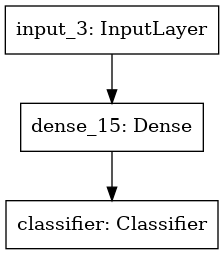

time: 512 ms (started: 2021-07-27 17:14:00 +08:00)


In [70]:
plot_model(model)

相反，您可以使用函数模型作为子类层或模型的一部分：

In [71]:
inputs = keras.Input(shape=(64,))

outputs = layers.Dense(1, activation="sigmoid")(inputs)

binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

class MyModel(keras.Model):
    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation="relu")
        self.classifier = binary_classifier
    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)
    
model = MyModel()

time: 31.7 ms (started: 2021-07-27 17:16:53 +08:00)


### 记住：为工作使用正确的工具

您已经了解了构建 Keras 模型的一系列工作流程，从最简单的工作流程（顺序模型）到最高级的工作流程（模型子类化）。什么时候应该使用一个？每一种都有其优点和缺点——选择最适合手头工作的一种。

通常，Functional API 为您提供了易用性和灵活性之间的很好的权衡。它还使您可以直接访问图层连接，这对于模型绘图或特征提取等用例非常强大。如果你使用函数式 API——也就是说，如果你的模型可以表示为层的有向无环图——我建议使用它而不是模型子类化。

展望未来，本书中的所有示例都将使用函数式 API——这仅仅是因为我们将使用的所有模型都可以表示为层图。然而，我们将频繁使用子类层。一般而言，使用包含子类层的功能模型可提供两全其美的好处：高开发灵活性，同时保留函数 API 的优势。

## 使用内置的训练和评估循环

逐步公开复杂性的原则——访问从简单到任意灵活的一系列工作流程，一次一个步骤——也适用于模型训练。 Keras 为您提供了不同的训练模型工作流程——它可以像对数据调用 fit() 一样简单，也可以像从头开始编写新的训练算法一样高级。

您已经熟悉 compile()、fit()、evaluate()、predict() 工作流程。 提醒一下，它看起来像这样：

In [4]:
from tensorflow.keras.datasets import mnist

# 创建一个模型（我们将其分解为一个单独的函数，以便以后重用）。
def get_mnist_model(): 
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

# 加载您的数据，保留一些用于验证。
(images, labels), (test_images, test_labels) = mnist.load_data() 
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()

# 通过指定优化器、要最小化的损失函数和要监控的指标来编译模型。
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

# 用于训练模型，可选择提供验证数据以监控 fit() 对未见数据的性能。
model.fit(train_images, train_labels,epochs=3, validation_data=(val_images, val_labels)) 

Epoch 1/3
1563/1563 [==============================] - 20s 10ms/step - loss: 0.2978 - accuracy: 0.9109 - val_loss: 0.1543 - val_accuracy: 0.9536
Epoch 2/3
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1616 - accuracy: 0.9537 - val_loss: 0.1177 - val_accuracy: 0.9698
Epoch 3/3
1563/1563 [==============================] - 16s 11ms/step - loss: 0.1393 - accuracy: 0.9614 - val_loss: 0.1187 - val_accuracy: 0.9684


time: 56.2 s (started: 2021-07-28 20:38:59 +08:00)


In [79]:
# 使用evaluate() 计算新数据的损失和度量。
test_metrics = model.evaluate(test_images, test_labels) 

313/313 [==============================] - 2s 7ms/step - loss: 0.1113 - accuracy: 0.9726
time: 2.43 s (started: 2021-07-27 17:37:46 +08:00)


In [80]:
# 使用 predict() 计算新数据的分类概率。
predictions = model.predict(test_images)

time: 959 ms (started: 2021-07-27 17:37:48 +08:00)


有几种方法可以自定义这个简单的工作流程：
* 提供您自己的自定义指标
* 将回调传递给 fit() 方法以安排在训练期间的特定时间点采取的行动

让我们来看看这些。

### 编写自己的指标

指标是衡量模型性能的关键——尤其是衡量模型在训练数据上的性能与其在测试数据上的性能之间的差异。 用于分类和回归的常用指标已经是内置 keras.metrics 模块的一部分——大多数时候，这就是你将使用的。 但是，如果您正在做任何不寻常的事情，您将需要能够编写自己的指标。 这很简单！

Keras 指标是 keras.metrics.Metric 类的子类。 与层类似，度量具有存储在 TensorFlow 变量中的内部状态。 与层不同，这些变量不会通过反向传播更新，因此您必须自己编写状态更新逻辑——这发生在 update_state() 方法中。

例如，这是一个测量均方根误差 (RMSE) 的简单自定义指标。

In [4]:
import tensorflow as tf
from tensorflow import keras

# 对类进行子类化。
class RootMeanSquaredError(keras.metrics.Metric): 
    
#     在构造函数中定义状态变量。 与layers一样，您可以访问 add_weight() 方法。
    def __init__(self, name="rmse", **kwargs): 
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(name="total_samples", 
                                             initializer="zeros", 
                                             dtype="int32")
#     在 update_state() 中实现状态更新逻辑。 y_true 参数是一批的目标（或标签），而代表来自模型的相应 y_pred 预测。 
#     为了匹配我们的 MNIST 模型，我们需要分类预测和整数标签。 您可以忽略 sample_weight 参数，我们不会在这里使用它。    
    def update_state(self, y_true, y_pred, sample_weight=None): 
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1]) 
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

time: 1.7 ms (started: 2021-07-28 06:28:08 +08:00)


您使用 result() 方法返回指标的当前值：

In [6]:
def result(self):
    return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

time: 1.02 ms (started: 2021-07-28 06:28:23 +08:00)


同时，您还需要公开一种无需重新实例化即可重置度量状态的方法——这使得相同的度量对象能够在不同的训练时期或在训练和评估中使用。 你这样做是 reset_states() 方法：

In [7]:
def reset_states(self):
    self.mse_sum.assign(0.)
    self.total_samples.assign(0)

time: 509 µs (started: 2021-07-28 06:29:48 +08:00)


自定义指标可以像内置指标一样使用。 让我们测试一下我们自己的指标：

In [ ]:
from tensorflow.keras import layers

model = get_mnist_model()

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels, epochs=3,validation_data=(val_images, val_labels))

In [ ]:
test_metrics = model.evaluate(test_images, test_labels)

您现在可以看到进度条显示模型的 RMSE。

### 使用回调函数

使用 model.fit() 在大型数据集上运行数十个 epoch 的训练运行可能有点像发射纸飞机：经过最初的冲动，您无法控制其轨迹或着陆点。 如果你想避免糟糕的结果（从而浪费纸飞机），最好不要使用纸飞机，而是使用能够感知其环境、将数据发送回其操作员并根据其当前状态自动做出转向决策的无人机 . Keras API 将帮助您将您对回调 model.fit() 的调用从纸飞机转换为可以自我反省并动态采取行动的智能自主无人机。

回调是一个对象（一个实现特定方法的类实例），它在调用 fit() 时传递给模型，并在训练期间由模型在不同时间点调用。 它可以访问有关模型状态及其性能的所有可用数据，并且可以采取行动：中断训练、保存模型、加载不同的权重集或以其他方式改变模型的状态。

以下是您可以使用回调的一些方法示例：
* 模型检查点——在训练期间的不同点保存模型的当前状态。
* 提前停止——当验证损失不再改善时中断训练（当然，保存训练期间获得的最佳模型）。
* 在训练过程中动态调整某些参数的值——比如优化器的学习率。
* 在训练期间记录训练和验证指标，或者在模型更新时可视化学习的表示——您熟悉的 fit() 进度条实际上是一个回调！

keras.callbacks 模块包括许多内置回调（这不是一个详尽的列表）：

In [ ]:
keras.callbacks.ModelCheckpoint
keras.callbacks.EarlyStopping
keras.callbacks.LearningRateScheduler
keras.callbacks.ReduceLROnPlateau
keras.callbacks.CSVLogger

让我们回顾一下其中的两个，让您了解如何使用它们：EarlyStopping 和 ModelCheckpoint。

**早期停止模型检查点和回调**

在训练模型时，很多事情一开始就无法预测。 特别是，您无法确定需要多少个 epoch 才能达到最佳验证损失。 到目前为止，我们的示例采用了训练足够多的 epoch 的策略，您开始过度拟合，使用第一次运行来确定要训练的合适的 epoch 数，然后最后使用这个最佳数从头开始新的训练运行。 当然，这种方法是浪费的。 处理此问题的更好方法是在您测量到验证损失不再改善时停止训练。 这可以使用 EarlyStopping 回调来实现。

一旦被监控的目标指标在固定数量的 epoch 内停止改进，EarlyStopping 回调就会中断训练。 例如，此回调允许您在开始过度拟合时立即中断训练，从而避免必须重新训练模型以减少 epoch 数。 此回调通常与 ModelCheckpoint 结合使用，它使您可以在训练期间不断保存模型（并且，可以选择仅保存当前的最佳模型：在 epoch 结束时实现最佳性能的模型版本） ：

In [17]:
# 回调通过 fit() 中的参数传递给模型，该参数包含一个回调列表。 您可以传递任意数量的回调。
callbacks_list = [
#     当改进停止时中断训练
    keras.callbacks.EarlyStopping(monitor="accuracy", #监控模型的验证准确性
                                  patience=1,),#当准确性停止提高超过一个时期（即两个时期）时中断训练
    #     在每个 epoch 后保存当前权重
    keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras", #目标模型文件的路径
                                    monitor="val_loss", #这两个参数意味着除非 val_loss 有所改进，
                                    save_best_only=True,)]#否则您不会覆盖模型文件，这使您可以在训练期间保持最佳模型。

model = get_mnist_model()

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]) #您监控准确性，因此它应该是模型指标的一部分。

# 请注意，由于回调将监视验证丢失和验证准确性，因此您需要将 validation_data 传递给对 fit() 的调用。
model.fit(train_images, 
          train_labels,
          epochs=10,
          callbacks=callbacks_list,
          validation_data=(val_images, val_labels))

Epoch 1/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.2929 - accuracy: 0.9136 - val_loss: 0.1616 - val_accuracy: 0.9565
Epoch 2/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.1652 - accuracy: 0.9532 - val_loss: 0.1200 - val_accuracy: 0.9666
Epoch 3/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.1369 - accuracy: 0.9636 - val_loss: 0.1197 - val_accuracy: 0.9700
Epoch 4/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1279 - accuracy: 0.9661 - val_loss: 0.1104 - val_accuracy: 0.9749
Epoch 5/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1155 - accuracy: 0.9704 - val_loss: 0.1023 - val_accuracy: 0.9765
Epoch 6/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1105 - accuracy: 0.9732 - val_loss: 0.1018 - val_accuracy: 0.9775
Epoch 7/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1064 - accuracy: 0.9750 - val_loss: 0.1053 - val_a

time: 2min 26s (started: 2021-07-28 06:45:56 +08:00)


请注意，您也可以在训练后手动保存模型——只需调用 model.save('my_checkpoint_path')。 要重新加载您保存的模型，只需使用：

In [18]:
model = keras.models.load_model("checkpoint_path.keras")

time: 147 ms (started: 2021-07-28 06:54:14 +08:00)


### 编写自己的回调函数

如果您需要在训练期间执行其中一个内置回调未涵盖的特定操作，您可以编写自己的回调。 回调是通过继承类 `keras.callbacks.Callback` 来实现的。 然后，您可以实现以下任意数量的透明命名方法，这些方法在训练期间的不同点被调用：

In [ ]:
on_epoch_begin(epoch, logs) #在每个周期开始时调用
on_epoch_end(epoch, logs) #在每个周期结束时调用
on_batch_begin(batch, logs) #在处理每批之前调用
on_batch_end(batch, logs) #在处理每批之后调用
on_train_begin(logs) #在训练开始时调用
on_train_end(logs) #在训练结束时调用

这些方法都使用一个参数调用，该参数是一个字典，其中包含有关前一个批次、时期或训练运行的信息日志：训练和验证指标等。 on_epoch_* 和 on_batch_* 方法也将周期或批次索引作为第一个参数（一个
整数）。

这是一个简单的示例，在训练期间保存每批损失值的列表，并在每个 epoch 结束时保存这些值的图表：

In [7]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))
        
    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), 
                 self.per_batch_losses,
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

time: 771 ms (started: 2021-07-28 10:55:04 +08:00)


让我们试驾一下：

Epoch 1/10
1563/1563 [==============================] - 18s 11ms/step - loss: 0.2935 - accuracy: 0.9140 - val_loss: 0.1501 - val_accuracy: 0.9580
Epoch 2/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1655 - accuracy: 0.9548 - val_loss: 0.1259 - val_accuracy: 0.9659
Epoch 3/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1407 - accuracy: 0.9616 - val_loss: 0.1110 - val_accuracy: 0.9712
Epoch 4/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.1267 - accuracy: 0.9669 - val_loss: 0.1147 - val_accuracy: 0.9718
Epoch 5/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.1211 - accuracy: 0.9698 - val_loss: 0.1105 - val_accuracy: 0.9759
Epoch 6/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1114 - accuracy: 0.9727 - val_loss: 0.1130 - val_accuracy: 0.9755
Epoch 7/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.1033 - accuracy: 0.9756 - val_loss: 0.1098 -

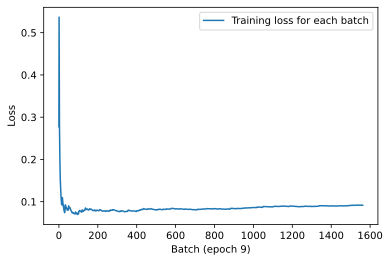

time: 2min 51s (started: 2021-07-28 10:55:07 +08:00)


In [8]:
model = get_mnist_model()

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.fit(train_images, 
          train_labels,
          epochs=10,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))

### 使用 TensorBoard 进行监控和可视化

为了进行良好的研究或开发良好的模型，您需要对实验期间模型内部发生的情况进行丰富、频繁的反馈。 这就是运行实验的重点：获取有关模型执行情况的信息——尽可能多的信息。 取得进展是一个反复的过程——一个循环：你从一个想法开始，并将其表达为一个实验，试图验证或否定你的想法。 您运行此实验并处理它生成的信息。 这激发了你的下一个想法。 您能够运行的此循环的迭代次数越多，您的想法就越精致和强大。 Keras 可以帮助您在尽可能短的时间内从想法到实验，而快速 GPU 可以帮助您尽快从实验到结果。 但是如何处理实验结果呢？ 这就是 TensorBoard 的用武之地。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gswm6ymyvjj31b60tggo9.jpg)

TensorBoard 是一个基于浏览器的应用程序，您可以在本地运行。 这是在训练期间监控模型内部发生的一切的最佳方式。 使用 TensorBoard，您可以：
* 在训练期间可视化监控指标
* 可视化您的模型架构
* 可视化激活和梯度的直方图
* 探索 3D 嵌入

如果您监控的信息不仅仅是模型的最终损失，您可以对模型做什么和不做什么有更清晰的认识，并且可以更快地取得进展。

将 TensorBoard 与 Keras 模型和 fit 方法一起使用的最简单方法是 keras.callbacks.TensorBoard 回调。

在最简单的情况下，只需指定您希望回调写入日志的位置，就可以了：

In [6]:
model = get_mnist_model()

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

tensorboard = keras.callbacks.TensorBoard(log_dir="./tensorboard_log",)

model.fit(train_images, train_labels,
          epochs=10,
          validation_data=(val_images, val_labels),
          callbacks=[tensorboard])

Epoch 1/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.2940 - accuracy: 0.9117 - val_loss: 0.1513 - val_accuracy: 0.9584
Epoch 2/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.1654 - accuracy: 0.9534 - val_loss: 0.1241 - val_accuracy: 0.9682
Epoch 3/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1403 - accuracy: 0.9621 - val_loss: 0.1125 - val_accuracy: 0.9714
Epoch 4/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1283 - accuracy: 0.9663 - val_loss: 0.1054 - val_accuracy: 0.9743
Epoch 5/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1175 - accuracy: 0.9699 - val_loss: 0.1067 - val_accuracy: 0.9756
Epoch 6/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.1119 - accuracy: 0.9728 - val_loss: 0.1043 - val_accuracy: 0.9768
Epoch 7/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.1066 - accuracy: 0.9748 - val_loss: 0.1100 -

time: 2min 40s (started: 2021-07-28 14:00:21 +08:00)


一旦模型开始运行，它将在目标位置写入日志。 如果您在本地机器上运行 Python 脚本，则可以使用以下命令启动本地 TensorBoard 服务器（请注意，如果您通过 TensorFlow 安装了 tensorboard 可执行文件，则应该已经可用；如果没有，您可以通过手动安装 TensorBoard pip pip 安装张量板）。

In [3]:
!tensorboard --logdir ./tensorboard_log

/bin/bash: tensorboard: 未找到命令


然后，您可以导航到命令返回的 URL 以访问 TensorBoard 界面。

如果您在 Colab 笔记本中运行脚本，则可以使用以下命令将嵌入式 TensorBoard 实例作为笔记本的一部分运行：

In [1]:
%load_ext tensorboard
%tensorboard --logdir ./tensorboard_log

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2021-07-28 14:40:14.777058: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/public/huangwei/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorboard_data_server/bin/server: /lib64/libc.so.6: version `GLIBC_2.18' not found (required by /public/huangwei/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorboard_data_server/bin/server)
Traceback (most recent call last):
  File "/public/huangwei/miniconda3/envs/tensorflow/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/public/huangwei/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/public/huangwei/miniconda3/envs/tensorflow/lib/python3.8/site-packages/absl/app.py", line 312, in run
    _run_main(main, args)
  File "/public/huangwei/mi

在 TensorBoard 界面中，您将能够监控训练和评估指标的实时图表：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gswnrn8eb8j316a0u0why.jpg)

## 编写自己的训练和评估循环

fit() 工作流在易用性和灵活性之间取得了很好的平衡。 这是你大部分时间都会用到的。 然而，它并不意味着支持深度学习研究人员可能想做的所有事情——即使是自定义指标、自定义损失和自定义回调。

毕竟，内置的 fit() 工作流程仅专注于监督学习：一种设置，其中存在与输入数据相关的已知（也称为标签或注释），以及根据这些目标计算损失的目标 以及模型的预测。 然而，并非所有形式的机器学习都属于这一类。 还有其他不存在明确目标的设置，例如生成学习（我们将在第 12 章中介绍）、自监督学习（从输入中获得目标）或强化学习（学习由偶然驱动） 奖励”——很像训练狗）。 即使你正在做常规的监督学习，作为一名研究人员，你可能想要添加一些需要低级灵活性的新颖花里胡哨

每当您发现自己处于内置 fit() 不够用的情况时，您将需要编写自己的自定义训练逻辑。 您已经在第 2 章和第 3 章中看到了低级训练循环的简单示例。提醒一下，典型训练循环的内容如下所示：
* 在“梯度磁带”中运行“前向传递”（计算模型的输出）以获得当前批次数据的损失值。
* 检索与模型权重有关的损失梯度。
* 更新模型的权重以降低当前批次数据的损失值。

根据需要对尽可能多的批次重复这些步骤。 这本质上是 fit() 引擎盖下的内容。 在本节中，您将学习从头开始重新实现，这将 fit() 为您提供编写您可能想出的任何训练算法所需的所有知识。 让我们来看看细节。

根据需要对尽可能多的批次重复这些步骤。 这本质上是 fit() 在引擎盖下所做的。 在本节中，您将学习从头开始重新实现 fit()，这将为您提供编写您可能想出的任何训练算法所需的所有知识。 

让我们来看看细节。

### 训练与推理

在您目前看到的低级训练循环示例中，第 1 步（前向传递）是通过`predictions = model(inputs)`完成的，第 2 步（检索由梯度磁带计算的梯度）是通过`gradients = tape.gradient(loss, model.weights)` 完成的。 在一般情况下，您实际上需要考虑两个微妙之处。

一些 Keras 层，例如层，在训练期间和 Dropout 训练期间（当您使用它们生成预测时）具有不同的行为。 这些层在其方法中公开了推理训练布尔参数。

一些 Keras 层，例如 Dropout 层，在推理期间和训练期间（当您使用它们生成预测时）具有不同的行为。 这些层在它们的 call() 方法中公开了一个训练布尔参数。

调用 dropout(inputs, training=True) 将删除一些激活条目，而调用 dropout(inputs, training=False) 什么也不做。

通过扩展，Functional 模型和 Sequential 模型也在它们的 call() 方法中公开了这个训练参数。

在前向传递期间调用 Keras 模型时，请记住传递 training=True！ 因此，我们的前向传递变成了predictions = model(inputs, training=True)。

此外，请注意，当您检索模型权重的梯度时，不应使用 tape.gradients(loss, model.weights)，而应使用 tape.gradients(loss, model.trainable_weights)。 实际上，层和模型拥有两种权重：
* “可训练权重”，旨在通过反向传播进行更新，以最大限度地减少模型的损失，例如密集层的内核和偏差。
* “不可训练的权重”，意味着在前向传递期间由拥有它们的层更新。 例如，如果您想要一个自定义层保留一个计数器，记录到目前为止已处理的批次数，该信息将存储在不可训练的权重中，并且在每个批次中，您的层会将计数器加一。

在 Keras 的内置层中，唯一具有不可训练权重的层是 BatchNormalization 层，我们将在第 9 章介绍。 BatchNormalization 层需要不可训练的权重，以跟踪有关均值和标准差的信息 通过它的数据，以便执行特征归一化的在线近似（您在第 6 章中学到的概念）。

考虑到这两个细节，监督学习训练步骤最终看起来像这样：

In [4]:
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradients(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(model.trainable_weights, gradients))

### 指标的低级使用

在低级训练循环中，您可能希望利用 Keras 指标（无论是内置指标中的自定义指标）。 您已经了解了指标 API：只需为每批目标和预测调用 update_state(y_true, y_pred)，然后使用 result() 查询当前指标值。

In [7]:
from tensorflow import keras

In [8]:
metric = keras.metrics.SparseCategoricalAccuracy()
targets = [0, 1, 2]
predictions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
metric.update_state(targets, predictions)
current_result = metric.result()
print(f"result: {current_result:.2f}")

result: 1.00


您可能还需要跟踪标量值的平均值，例如模型的损失。 您可以通过 keras.metrics.Mean 指标执行此操作：

In [9]:
values = [0, 1, 2, 3, 4]
mean_tracker = keras.metrics.Mean()
for value in values:
    mean_tracker.update_state(value)
print(f"Mean of values: {mean_tracker.result():.2f}")

Mean of values: 2.00


当您想重置当前结果时（在训练时期开始或评估开始时），请记住使用 `metric.reset_state()`。

### 完整的训练和评估循环

让我们将前向传递、后向传递和指标跟踪组合成一个类似 fit() 的训练步骤函数，该函数接受一批数据和目标，并返回将要显示的日志
通过 fit() 进度条：

In [5]:
model = get_mnist_model()

# 准备损失函数。
loss_fn = keras.losses.SparseCategoricalCrossentropy()
# 准备优化器。
optimizer = keras.optimizers.RMSprop()
# 准备要监控的指标列表。
metrics = [keras.metrics.SparseCategoricalAccuracy()]
#     准备一个指标跟踪器来跟踪损失平均值。
loss_tracking_metric = keras.metrics.Mean()

def train_step(inputs, targets):
            
#     运行前向传递。 请注意，我们传递了 training=True。
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True) 
        loss = loss_fn(targets, predictions)
        
# 运行反向传播。 请注意，我们使用了 model.trainable_weights。   
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights)) 

    # 跟踪指标
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions) 
        logs[metric.name] = metric.result()
        
#     跟踪损失平均值。
    loss_tracking_metric.update_state(loss)
    
#     返回指标和损失的当前值。
    logs["loss"] = loss_tracking_metric.result() 
    return logs

time: 218 ms (started: 2021-07-28 20:41:16 +08:00)


我们需要在每个时期开始时和运行评估之前重置指标的状态。 这是一个实用函数来做到这一点：

> 编写分步训练循环：重置指标

In [6]:
def reset_metrics():
    for metric in metrics:
        metric.reset_states()
    loss_tracking_metric.reset_states()

time: 1.29 ms (started: 2021-07-28 20:43:02 +08:00)


我们现在可以布置我们完整的训练循环。 请注意，我们使用 tf.data.Dataset 对象将 NumPy 数据转换为迭代器，该迭代器以大小为 32 的批次迭代数据。

> 编写分步训练循环：循环本身

In [7]:
training_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
training_dataset = training_dataset.batch(32)

epochs = 3

for epoch in range(epochs):
    reset_metrics()
    for inputs_batch, targets_batch in training_dataset:
        logs = train_step(inputs_batch, targets_batch)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        print(f"...{key}: {value:.4f}")

Results at the end of epoch 0
...sparse_categorical_accuracy: 0.9155
...loss: 0.2855
Results at the end of epoch 1
...sparse_categorical_accuracy: 0.9537
...loss: 0.1658
Results at the end of epoch 2
...sparse_categorical_accuracy: 0.9619
...loss: 0.1398
time: 4min 20s (started: 2021-07-28 20:48:45 +08:00)


这是评估循环：一个简单的 for 循环，它重复调用 test_step 函数，该函数处理单批数据。 test_step 函数只是 train_step 逻辑的一个子集。 它省略了处理更新模型权重的代码，也就是说，所有涉及 GradientTape 和优化器的代码。

In [9]:
def test_step(inputs, targets):
#    请注意，我们传递了 training=False
    predictions = model(inputs, training=False) 
    loss = loss_fn(targets, predictions)
    
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()

for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
    
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

Evaluation results:
...val_sparse_categorical_accuracy: 0.9684
...val_loss: 0.1284
time: 11.8 s (started: 2021-07-28 21:12:55 +08:00)


恭喜——你刚刚重新实现了 fit() 和 evaluate()！ 或者几乎：fit() &evaluate() 支持更多功能，包括大规模分布式计算，这需要更多的工作。 它还包括几个关键的性能优化。

我们来看一个关键的优化：TensorFlow 函数编译。

### 使用 tf.function 使其快速

您可能已经注意到，尽管实现了基本相同的逻辑，但您的自定义循环的运行速度明显慢于内置的 fit() 和 evaluate() 。 这是因为默认情况下，TensorFlow 代码是逐行执行的，“急切地”执行，很像 NumPy 代码或常规 Python 代码。 Eager Execution 使调试代码更容易，但从性能的角度来看，它远非最佳。

将 TensorFlow 代码转换为编译计算图的性能更高，可以以逐行解释代码的方式进行全局优化。 执行此操作的语法非常简单：只需在执行前向要编译的任何函数添加 @tf.function 即可。 像这样：

In [10]:
@tf.function #唯一改变的行
def test_step(inputs, targets):
#    请注意，我们传递了 training=False
    predictions = model(inputs, training=False) 
    loss = loss_fn(targets, predictions)
    
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()

for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
    
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

Evaluation results:
...val_sparse_categorical_accuracy: 0.9684
...val_loss: 0.1284
time: 2.51 s (started: 2021-07-28 21:19:05 +08:00)


在 Colab CPU 上，我们从运行评估循环所需的 1.80 秒变为仅 0.8 秒。 快多了！

请记住：在调试代码时，最好不要任何 @tf.function 装饰器，而是急切地运行它。 以这种方式跟踪错误会更容易。 一旦您的代码可以运行并且您想使其更快，请将 @tf.function 装饰器添加到您的训练步骤和评估步骤 - 或任何其他对性能至关重要的函数。

### 利用 fit() 与自定义训练循环

在上面的部分中，我们完全从头开始编写自己的训练循环。 这样做为您提供了最大的灵活性，但您最终会编写大量代码，同时错过了许多方便的 fit() 功能，例如回调或对分布式训练的内置支持。

如果您需要自定义训练算法，但仍想利用内置 Keras 训练逻辑的强大功能，该怎么办？ fit() 和从头开始编写的训练循环之间实际上有一个中间立场：您可以提供自定义训练步骤函数，让框架完成其余的工作。

您可以通过覆盖 Model 类的 train_step() 方法来做到这一点。 这是 fit() 为每批数据调用的函数。 然后你就可以像往常一样调用 fit() 了——它会在后台运行你自己的学习算法。

这是一个简单的例子：
* 我们创建了一个新类，它是 keras.Model 的子类。
* 我们重写方法 train_step(self, data)。 它的内容与我们在上一节中使用的内容几乎相同。
* 我们返回一个字典，将度量名称（包括损失）映射到它们的当前值。

In [11]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
# 该度量对象将用于跟踪训练和评估期间每批损失的平均值。
loss_tracker = keras.metrics.Mean(name="loss")

class CustomModel(keras.Model):
#     我们覆盖了 train_step 方法。
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
#             请注意，我们使用 self(inputs, training=True) 而
#             不是 model(inputs, training=True)，因为我们的模型是类本身。
            predictions = self(inputs, training=True)
            loss = loss_fn(targets, predictions)
        
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        
#         我们更新了跟踪损失平均值的损失跟踪指标。
        loss_tracker.update_state(loss)
#         我们通过查询损失跟踪器指标返回到目前为止的平均损失。
        return {"loss": loss_tracker.result()}

# 在 model.metrics 属性中列出损失跟踪器指标使模型能够在每个时期的开始和对评估（）的调用开始时
# 自动对其调用 reset_states()——因此您不必手工这样做。 您希望跨周期重置的任何指标都应在此处列出。
    @property
    def metrics(self):
        return [loss_tracker]

time: 13.7 ms (started: 2021-07-28 21:32:19 +08:00)


我们现在可以实例化我们的自定义模型，编译它（我们只通过优化器，因为损失已经在模型之外定义了），然后像往常一样使用 fit() 训练它。

In [12]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop())
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 15s 8ms/step - loss: 0.2967
Epoch 2/3
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1661
Epoch 3/3
1563/1563 [==============================] - 13s 9ms/step - loss: 0.1410


time: 42.5 s (started: 2021-07-28 21:33:05 +08:00)


注意：
* 此模式不会阻止您使用 Functional API 构建模型。 无论您是在构建顺序模型、功能 API 模型还是子类模型，您都可以这样做。
* 当您覆盖 train_step 时，您不需要使用 @tf.function 装饰器 - 框架会为您完成。

现在，指标如何，以及如何通过 compile() 配置损失？ 调用 compile() 后，您可以访问：
* self.compiled_loss——你传递给compile()的损失函数。
* self.compiled_metrics——你传递的指标列表的包装器，它允许你调用 self.compiled_metrics.update_state() 来一次更新你的所有指标。
* self.metrics——你传递给 compile() 的实际指标列表。 请注意，它还包括一个跟踪损失的指标，类似于我们之前手动使用 loss_tracking_metric 所做的。

因此我们可以这样写：

In [13]:
class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compiled_loss(targets, predictions)
            
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        
        self.compiled_metrics.update_state(targets, predictions) 
        
        return {m.name: m.result() for m in self.metrics}

time: 11.2 ms (started: 2021-07-28 21:40:03 +08:00)


让我们试试看：

In [14]:
inputs = keras.Input(shape=(28 * 28,))

features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 15s 9ms/step - loss: 0.2950 - sparse_categorical_accuracy: 0.9127
Epoch 2/3
1563/1563 [==============================] - 13s 9ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.9530
Epoch 3/3
1563/1563 [==============================] - 13s 8ms/step - loss: 0.1379 - sparse_categorical_accuracy: 0.9621


time: 41.5 s (started: 2021-07-28 21:41:03 +08:00)


那是很多信息，但现在您已经足够了解使用 Keras 做几乎任何事情。

## 章节总结

* Keras 提供了一系列不同的工作流程，基于复杂性的渐进披露原则。 它们都可以顺利地互操作。
* 您可以通过 Sequential 类、Functional API 或通过子类化该类来构建模型。 大多数情况下，您将使用 Functional API。
* 通过默认的 fit() 和evaluate() 方法训练和评估模型的最简单方法。
* Keras 回调提供了一种在调用 fit() 期间监控模型的简单方法，并根据模型的状态自动采取行动。
* 您还可以通过覆盖 train_step() 方法完全控制 fit() 所做的事情。
* 除了 fit()，您还可以完全从头开始编写自己的训练循环。 这对于实施全新训练算法的研究人员很有用。